In this guide, you'll learn about Planet's automatic detection of pixels which are cloudy or otherwise obscured, so that you can make more intelligent choices about whether the data meets your needs.

In 2018, Planet undertook a project to improve cloud detection, and this guide will focus on the improved metadata that can be used for filtering and the new `udm2` asset that provides access to detail classification of every pixel. This new information will be available for all `PSScene4Band` and `PSOrthoTile` items created after 2018-08-01 and for some items before this date (note that a very small number of items created after this date are without the `udm2` asset). Planet is not currently planning on removing old cloud cover metadata or the old `udm` asset.

### Full specification

The full specification for the `udm2` asset and the related metadata fields can be found in the [UDM 2]({filename}../pages/api/itemsassets/udm2.md) section of the API documentation.

## Finding clear imagery

One of the benefits of accurate and automated cloud detection is that it allows users to filter out images that don't meet a certain quality threshold. Planet's Data API allows users to [search]({filename}../pages/api/searchesfiltering.md) based on the value of the imagery metadata.

For example, if you are using the Planet command-line tool, you can search for all four-band PlanetScope scenes that have less than 10% cloud cover in them with the following:

    planet data search --item-type PSScene4Band --range cloud_percent lt 10
    
Planet's cloud detection algorithm classifies every pixel into one of six different categories, each of which has a corresponding metadata field that reflects the percentage of data that falls into the category.

| Class | Metadata field |
| --- | --- |
| clear | `clear_percent` |
| snow | `snow_ice_percent` |
| shadow | `shadow_percent` |
| light haze | `light_haze_percent` |
| heavy haze| `heavy_haze_percent` |
| cloud | `cloud_percent` |

These can be combined to refine search results even further. An example of searching for imagery that has less than 10% clouds and less than 10% heavy haze:

    planet data search --item-type PSScene4Band --range cloud_percent lt 10 --range heavy_haze_percent lt 10
    
Every pixel will be classified into only one of the categories above; a pixel may be snowy or obscured by a shadow but it can not be both at the same time!

The following example will show how to do a search for imagery that is at least 90% clear using Planet's Python client.

In [1]:
from planet import api
client = api.ClientV1()

In [10]:
# build a filter for the AOI
filter = api.filters.range_filter("clear_percent", gte=90)

# show the structure of the filter
print(filter)

{'config': {'gte': 90}, 'field_name': 'clear_percent', 'type': 'RangeFilter'}


In [8]:
# we are requesting PlanetScope 4 Band imagery
item_types = ['PSScene4Band']
request = api.filters.build_search_request(filter, item_types)

# this will cause an exception if there are any API related errors
results = client.quick_search(request)

In [9]:
# print out the ID of the most recent 10 images that matched
for item in results.items_iter(10):
    print('%s' % item['id'])

20190316_174936_101e
20190316_193503_101e
20190209_074408_0f4c
20190209_154011_1_0f2b
20190209_154000_0f2b
20190209_101802_100e
20190209_101801_100e
20190209_101800_100e
20190209_043131_0f2a
20190209_044523_1053


## The `udm2` asset

In addition to metadata for filtering, the `udm2` asset provides a pixel-by-pixel map that identifies the classification of each pixel.

In the example below, cloudy pixels are highlighted in yellow, shadows in red and light haze in blue.

| Original image | `udm2` overlay |
| :--- | :--- |
| ![20190228_172942_0f1a_3B_Visual.tif]({attach}udm2/20190228_172942_0f1a_orig.png) |  ![Detected clouds]({attach}udm2/20190228_172942_0f1a_map.png) |
| `20190228_172942_0f1a_3B_Visual.tif` | `20190228_172942_0f1a_udm2.tif` |

The `udm2` structure is to use a separate band for each classification type. Band 2, for example, indicates that a pixel is snowy when its value is 1, band 3 indicates shadow and so on. 

The following Python will download the data above and then display pixels that fall into a certain classifications.

In [12]:
item_type = "PSScene4Band"
item_id = "20190228_172942_0f1a"

In [15]:
import time

# activate assets
assets = client.get_assets_by_id("PSScene4Band", item_id).get()
client.activate(assets["analytic"])
client.activate(assets["udm2"])

# wait until activation completes
while True:
    assets = client.get_assets_by_id("PSScene4Band", item_id).get()
    if assets["analytic"].has_key("location") and assets["udm2"].has_key("location"):
            break 
    time.sleep(10)    

In [16]:
# start downloads
r1 = client.download(assets["analytic"], callback=api.write_to_file())
r2 = client.download(assets["udm2"], callback=api.write_to_file())

In [17]:
# wait until downloads complete
r1.wait()
r2.wait()
img_file = r1.get_body().name
udm_file = r2.get_body().name
print("image: {}".format(img_file))
print("udm2:  {}".format(udm_file))

image: 20190228_172942_0f1a_3B_AnalyticMS.tif
udm2:  20190228_172942_0f1a_udm2.tif


In [18]:
import rasterio
from rasterio.plot import show

In [22]:
with rasterio.open(udm_file) as src:
    shadow_mask = src.read(3).astype(bool)
    cloud_mask = src.read(6).astype(bool)

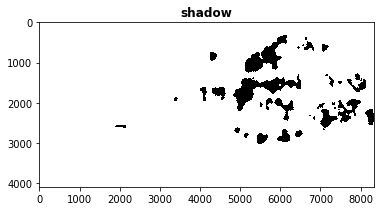

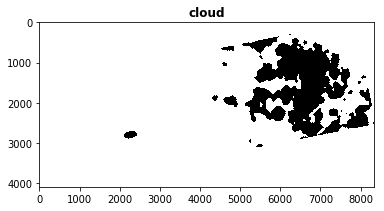

In [23]:
show(shadow_mask, title="shadow", cmap="binary")
show(cloud_mask, title="cloud", cmap="binary")

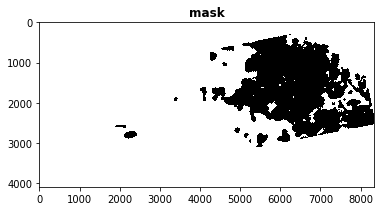

In [24]:
mask = shadow_mask + cloud_mask
show(mask, title="mask", cmap="binary")

In [25]:
with rasterio.open(img_file) as src:
    profile = src.profile
    img_data = src.read([3, 2, 1], masked=True) / 10000.0 # apply RGB ordering and scale down

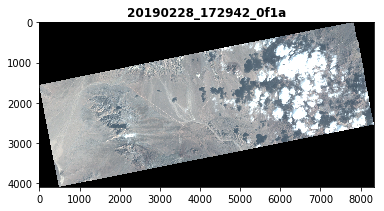

In [26]:
show(img_data, title=item_id)

In [27]:
img_data.mask = mask
img_data = img_data.filled(fill_value=0)

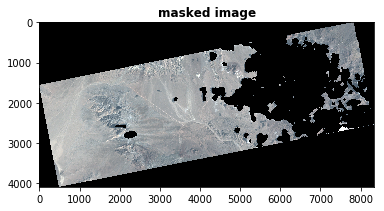

In [28]:
show(img_data, title="masked image")

The image stored in `img_data` now has cloudy pixels masked out and can be saved or used for analysis.